<a href="https://colab.research.google.com/github/gulmert89/dsBootcamp/blob/master/burning_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HackerEarth Machine Learning Challenge
## Predict the employee burn out rate

**ABOUT CHALLENGE** <br>
> *To win in the marketplace, you must first win in the workplace.*
~ Doug Conant

> And rightly so! Happy and healthy employees are indisputably more productive at work, and in turn, help the business flourish profoundly.

> However, since working from home has become the new strange normal, over 69% of employees have been showing burnout symptoms globally (source: Monster poll). This rate of burnout is indeed alarming and the likes of Google and Cisco (even HackerEarth!) are taking steps that ensure wellness and reduce burnout among employees.

> On the occasion of World Mental Health Day this October 10th, your organization has stepped in to help its employees plan their weekly calendars appropriately so as to prevent burning out. Your task, as a Machine Learning engineer, is to build a Machine Learning model that predicts burnout rate based on numerous factors such as WFH setup, resources, mental fatigue score, and the like.


***
**Participant:** [Mert Gül](https://www.linkedin.com/in/gulmert89/)<br>
Hackathon Link: [HackerEarth](https://www.hackerearth.com/challenges/competitive/hackerearth-machine-learning-challenge-predict-burnout-rate/)<br>
More information on the dataset: [Kaggle](https://www.kaggle.com/blurredmachine/are-your-employees-burning-out)
***

# 1\. Introduction

Dataset:
* **Employee ID**: The unique ID allocated for each employee (example: fffe390032003000)
* **Date of Joining**: The date-time when the employee has joined the organization (example: 2008-12-30)
* **Gender**: The gender of the employee (Male/Female)
* **Company Type**: The type of company where the employee is working (Service/Product)
* **WFH Setup Available**: Is the work from home facility available for the employee (Yes/No)
* **Designation**: The designation of the employee of work in the organization.
    * In the range of [0.0, 5.0] bigger is higher designation.
* **Resource Allocation**: The amount of resource allocated to the employee to work, ie. number of working hours.
    * In the range of [1.0, 10.0] (higher means more resource)
* **Mental Fatigue Score**: The level of fatigue mentally the employee is facing.
    * In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.
* **Burn Rate**: The value we need to predict for each employee telling the rate of Bur out while working.
    * In the range of [0.0, 1.0] where the higher the value is more is the burn out.

## 1.1 Imports & Dataset

In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/My Drive/Colab Notebooks/Predict the employee burn out rate"

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Predict the employee burn out rate


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

***
# 2\. Preprocessing

## 2.1 Examine The Dataset

In [4]:
train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [6]:
# number of unique values per variable
train.nunique()

Employee ID             22750
Date of Joining           366
Gender                      2
Company Type                2
WFH Setup Available         2
Designation                 6
Resource Allocation        10
Mental Fatigue Score      101
Burn Rate                 101
dtype: int64

In [7]:
# number of empty values
train.isnull().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [8]:
# number of empty values (test)
test.isnull().sum()

Employee ID             0
Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
dtype: int64

## 2.2 Processing The Variables

In [9]:
# cosmetic configurations
sns.set_style(style="whitegrid")

title_font = {"family":"sans-serif", 
              "weight":"bold", 
              "color":"darkgreen", 
              "size":16}

axis_font = {"family":"serif", 
             "weight":"normal", 
             "color":"darkgreen", 
             "size":14}

### 2.2.1 One-Hot Encoding

It would be useful to convert these columns;
* Gender
* Company Type
* WFH Setup Available<br>

to binary values by **one-hot encoding**.

#### 2.2.1.1 Train Set

In [10]:
is_male = pd.get_dummies(train.Gender, drop_first=True)
is_service = pd.get_dummies(train["Company Type"], drop_first=True)
wfh_available = pd.get_dummies(train["WFH Setup Available"], drop_first=True)

In [11]:
for loc, column in enumerate(["is_male", "is_service", "wfh_available"], start=2):
    train.insert(loc=loc, column=column, value=eval(column))

train.drop(columns=["Gender", "Company Type", "WFH Setup Available"], axis=1, inplace=True)

In [12]:
train.head()

,Employee ID,Date of Joining,is_male,is_service,wfh_available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,0,1,0,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,1,1,1,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,0,0,1,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,1,1,1,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,0,1,0,3.0,7.0,6.9,0.52


#### 2.2.1.2 Test Set

In [13]:
is_male = pd.get_dummies(test.Gender, drop_first=True)
is_service = pd.get_dummies(test["Company Type"], drop_first=True)
wfh_available = pd.get_dummies(test["WFH Setup Available"], drop_first=True)

for loc, column in enumerate(["is_male", "is_service", "wfh_available"], start=2):
    test.insert(loc=loc, column=column, value=eval(column))

test.drop(columns=["Gender", "Company Type", "WFH Setup Available"], 
          axis=1, 
          inplace=True)

### 2.2.2 The Column: "Date of Joining"
All the employees in the dataset seem to join in 2008. Thus, omiting the year and converting the dates to integers (just to days) ***might*** help us a bit along the way. Here what we are going to do is:<br>
* **Remove the year**
* **Convert month + day to only days**
    * *Example-1:* join date of 01-20 (Jan 20th) will have $1*31 + 20 = 51$ days
    * *Example-2:* join date of 12-30 (Dec 30th) will have $2*31 + 30 = 402$ days
* **Inverse the sorting** because the smaller the integers are, the more experienced employee will be.
    * *Example:* So, the newest guy will have the maximum, the oldest will have the minimum days, right?
    * To inverse the situation, a simple calculation will be performed:
        * At the end, the oldest guy will have $|newGuysDays - oldGuysDays|$ in total w.r.t the new guy.
        * And the newest guy will have 0 days.
* Finally, **Normalize the numbers** to work with them better.<br>

**Note:** All these process would be in vain because it might not affect the model at all. We will see :)

In [14]:
%%time
month_dict = {"01":31, "02":29, "03":31, 
              "04":30, "05":31, "06":30, 
              "07":31, "08":31, "09":30, 
              "10":31, "11":30, "12":31}

for dataset in (train, test):
    for i in range(len(dataset)):
        x = dataset["Date of Joining"][i].split("-")    # sample output: ['2008', '09', '30']
        x = eval(f"{int(x[1])} * {month_dict[x[1]]} + {int(x[2])}")    # sample output: 300
        dataset.loc[i, "Date of Joining"] = x

    dataset["Date of Joining"] = dataset["Date of Joining"].astype("float32")
    dataset["Date of Joining"] = abs(dataset["Date of Joining"] - dataset["Date of Joining"].max())
    dataset["Date of Joining"] /= dataset["Date of Joining"].max()

CPU times: user 17.7 s, sys: 55.4 ms, total: 17.7 s
Wall time: 17.6 s


### 2.2.3 NaN Values

In [15]:
# there are NaNs in the most critical variables
# let's dive into the details
resource_nan = train["Resource Allocation"].isna()
mental_nan = train["Mental Fatigue Score"].isna()
burnrate_nan = train["Burn Rate"].isna()

# No "Burn Rate" & "Mental Fatigue Score" values
train[(burnrate_nan) & (mental_nan)]

,Employee ID,Date of Joining,is_male,is_service,wfh_available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
45,fffe31003500330034003700,0.404313,1,1,1,2.0,3.0,NaN,NaN
47,fffe3500320032003000,0.765499,0,0,1,3.0,6.0,NaN,NaN
122,fffe31003400350030003200,0.584906,0,0,0,3.0,5.0,NaN,NaN
127,fffe3900340036003300,0.921833,1,1,0,3.0,5.0,NaN,NaN
135,fffe32003200360039003000,0.641509,0,1,1,1.0,4.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
21507,fffe3300370033003600,0.911051,1,1,0,2.0,4.0,NaN,NaN
21701,fffe3400360038003300,0.126685,1,0,1,2.0,4.0,NaN,NaN
21888,fffe31003900360035003200,0.792453,1,1,0,3.0,6.0,NaN,NaN
21937,fffe3700350034003500,0.318059,1,1,0,3.0,6.0,NaN,NaN


We can roughly predict the **Burn Rate** by **Mental Fatigue Score** (and vice-versa) but the absence of these values gives us a hard time and trying to predict the **Burn Rate** would be an example of overestimation. Thus we had better remove these double-NaN values to make things simpler.

In [16]:
# Index values of NaN values of "Burn Rate" & "Mental Fatigue Score"
double_nan_indices = train[(burnrate_nan) & (mental_nan)].index

train.drop(index=double_nan_indices, axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)
del double_nan_indices, is_male, is_service, wfh_available

In [17]:
# okay, what else?
train.isna().sum()

Employee ID                0
Date of Joining            0
is_male                    0
is_service                 0
wfh_available              0
Designation                0
Resource Allocation     1366
Mental Fatigue Score    1945
Burn Rate                952
dtype: int64

Before we move on, it would be a wise practice to check the correlations of the variables to form a solid idea on what to do with the NaN values.

In [18]:
train_corr = train.corr()

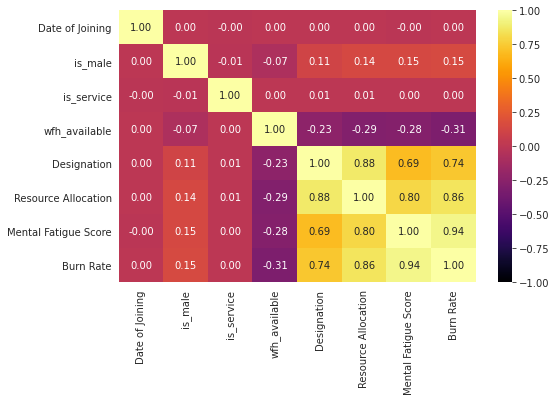

In [19]:
plt.figure(figsize=(8,5))
sns.heatmap(data=train_corr, 
            annot=True, 
            fmt=".2f", 
            vmin=-1, 
            vmax=1, 
            cmap="inferno")
plt.yticks(rotation=0)
plt.show()

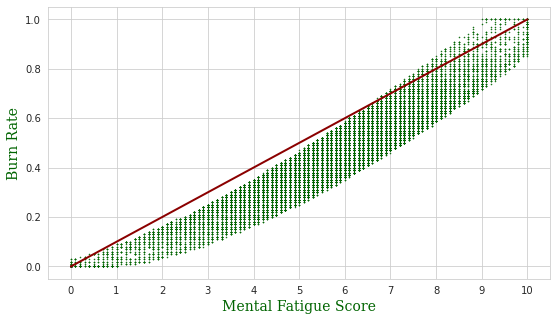

In [20]:
# We have very high correlation between some of the variables.
# Let's focus on "Mental Fatigue Score" and "Burn Rate"
plt.figure(figsize=(9, 5))
plt.scatter("Mental Fatigue Score", "Burn Rate", data=train, s=0.3, c="darkgreen")
plt.plot([0,10], [0, 1], linewidth=2, c="darkred")
plt.xlabel("Mental Fatigue Score", fontdict=axis_font)
plt.ylabel("Burn Rate", fontdict=axis_font)
plt.xticks(range(0,11))
plt.show()

The correlation is almost linear.<br>We may fill the gaps by using this high correlation. "Interpolation" could be our savior. 

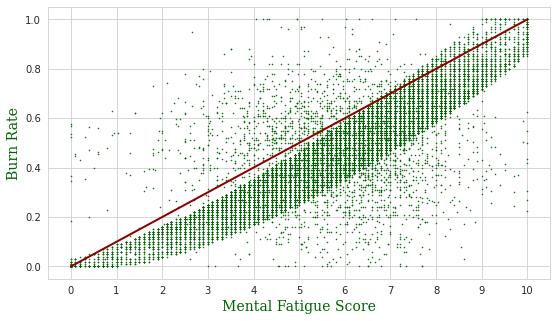

In [21]:
# to keep things safe, let's play on a copy of our train dataset
train_copy = pd.DataFrame()
for i in train.columns[-3:]:
    fill_with = train[i].interpolate(method="linear")
    train_copy[i] = train[i].fillna(fill_with, inplace=False)

plt.figure(figsize=(9, 5))
plt.scatter("Mental Fatigue Score", "Burn Rate", data=train_copy, s=0.3, c="darkgreen")
plt.plot([0,10], [0, 1], linewidth=2, c="darkred")
plt.xlabel("Mental Fatigue Score", fontdict=axis_font)
plt.ylabel("Burn Rate", fontdict=axis_font)
plt.xticks(range(0,11))
plt.show()
del train_copy

Random interpolation over the data made the dataset unnecessarily noisy. That why we should consider the correlations between the variables.<br>The things we are going to do are:<br>
* Create a copy of the dataset with *NaN-free* values on "Mental Fatigue Score" & "Burn Rate" variables
    * Because the interpolation will calculate the relationship in-between
* Bake the interpolation function, i.e $y = f(x)$
* Predict the NaN values by the function and replace them with the new values

...but first, let's look at the original values for the last time:

In [22]:
describe_original = train.describe()
describe_original

,Date of Joining,is_male,is_service,wfh_available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22578.000000,22578.000000,22578.000000,22578.000000,22578.000000,21212.000000,20633.000000,21626.000000
mean,0.507425,0.476482,0.652228,0.540305,2.178935,4.481001,5.728188,0.452005
std,0.286254,0.499458,0.476274,0.498384,1.134938,2.046963,1.920839,0.198226
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.277628,0.000000,0.000000,0.000000,1.000000,3.000000,4.600000,0.310000
50%,0.495957,0.000000,1.000000,1.000000,2.000000,4.000000,5.900000,0.450000
75%,0.754717,1.000000,1.000000,1.000000,3.000000,6.000000,7.100000,0.590000
max,1.000000,1.000000,1.000000,1.000000,5.000000,10.000000,10.000000,1.000000


In [23]:
from scipy import interpolate

In [24]:
# Let's create the copy of our dataset and
# make sure that there are no NaN values in
# "Mental Fatigue Score" & "Burn Rate" variables

train_copy = train.copy(deep=True)

not_na1 = train_copy["Mental Fatigue Score"].notna()
not_na2 = train_copy["Burn Rate"].notna()

train_copy = train_copy[(not_na1) & (not_na2)]
del not_na2, not_na1

In [25]:
# function to find the burn rate
fn_burn = interpolate.interp1d(x=train_copy["Mental Fatigue Score"], 
                               y=train_copy["Burn Rate"], 
                               kind="linear", 
                               fill_value=None)
# function to find the mental fatigue score
fn_mental = interpolate.interp1d(y=train_copy["Mental Fatigue Score"], 
                                 x=train_copy["Burn Rate"], 
                                 kind="linear", 
                                 fill_value=None)

In [26]:
# get rid of these NaNs
for i in train[train["Burn Rate"].isna()].index:
    train.loc[i, "Burn Rate"] = fn_burn(train.loc[i, "Mental Fatigue Score"])
    
for i in train[train["Mental Fatigue Score"].isna()].index:
    train.loc[i, "Mental Fatigue Score"] = fn_mental(train.loc[i, "Burn Rate"])

In [27]:
# well, what now?
train.isna().sum()

Employee ID                0
Date of Joining            0
is_male                    0
is_service                 0
wfh_available              0
Designation                0
Resource Allocation     1366
Mental Fatigue Score       0
Burn Rate                  0
dtype: int64

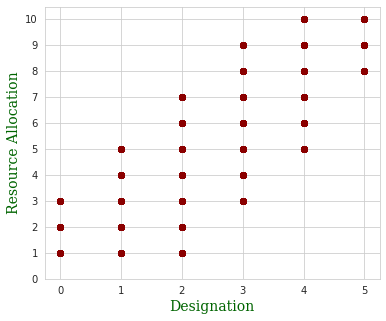

In [28]:
# remember that "Resource Allocation" is also highly correlated with Designation.
plt.figure(figsize=(6, 5))
plt.scatter("Designation", "Resource Allocation", data=train, c="darkred")
plt.xlabel("Designation", fontdict=axis_font)
plt.ylabel("Resource Allocation", fontdict=axis_font)
plt.yticks(range(0,11))
plt.show()

In [29]:
# We will get the mean of each "Designation" value and replace the NaN with them 
# Here, an example: 
temp_value = train["Resource Allocation"][train["Designation"]==1].mean()

print(f"The mean value of Resource Allocation where \
Designation == 1 is: {temp_value:.2f}")

The mean value of Resource Allocation where Designation == 1 is: 2.58


In [30]:
for i in range(6):    # 0 to 5, Designation values
    mean_value = train["Resource Allocation"][train["Designation"]==i].mean()
    
    # condition: "Designation" == i AND "Resource Allocation" is NaN
    condition = (train["Designation"]==i) & (train["Resource Allocation"].isna())
    
    # all NaN values are converted to mean values:
    train.loc[condition, "Resource Allocation"] = mean_value

del temp_value, train_copy, fn_burn, fn_mental

In [31]:
# ...and it's gone!
train.isna().sum()

Employee ID             0
Date of Joining         0
is_male                 0
is_service              0
wfh_available           0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Burn Rate               0
dtype: int64

As can be seen below, standard deviations are almost the same. Yay!

In [32]:
describe_botox = train.describe()

print("--------------- Original Data ---------------")
display(describe_original.iloc[:3, -3:])
print("\n--------------- Cleaned Data ---------------")
display(describe_botox.iloc[:3, -3:])

--------------- Original Data ---------------


,Resource Allocation,Mental Fatigue Score,Burn Rate
count,21212.000000,20633.000000,21626.000000
mean,4.481001,5.728188,0.452005
std,2.046963,1.920839,0.198226



--------------- Cleaned Data ---------------


,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22578.000000,22578.000000,22578.000000
mean,4.480784,5.718075,0.452212
std,2.031909,1.924218,0.198125


***

## 2.3 Bonus: A Fancy Way of EDA

This is a module that I've recently discovered. As title stated, it's a "fancier" way of exploratory data analysis with an interactive GUI.

*Note-1: The module needs to be updated to be used on Colab.<br>Please use the command and restart the runtime:*

<code>!pip install -U pandas-profiling</code>

*Note-2: I commented out the codes because GitHub doesn't show the interactive stuff on its page even though it keeps the files on the cache. So please uncomment them and feel free to explore our cleaned data.*

Update & import the module:

In [33]:
# !pip install -U pandas-profiling

In [34]:
# from pandas_profiling import ProfileReport

**Profile Report**

In [35]:
# profile = ProfileReport(train, title="Profiling Report", explorative=True)
# profile.to_notebook_iframe()

(Optional) Export the report as an html file:

In [36]:
# profile.to_file("./burning_out_report.html")

***
# 3\. Training & Validation

## 3.1 Data Preparation

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [38]:
# 25% of the train set is split as a validation set
X_train, X_val, \
y_train, y_val = train_test_split(train.iloc[:, 1:-1],
                                         train.iloc[:, -1], 
                                         test_size=0.25, 
                                         shuffle=True, 
                                         random_state=19)
X_test = test.iloc[:, 1:]
y_test = None

print("Shape of the train set:\nX_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nShape of the validation set:\nX_val:", X_val.shape)
print("y_val:", y_val.shape)
print("\nShape of the test set:\nX_test:", X_test.shape)

Shape of the train set:
X_train: (16933, 7)
y_train: (16933,)

Shape of the validation set:
X_val: (5645, 7)
y_val: (5645,)

Shape of the test set:
X_test: (12250, 7)


In [39]:
scale = StandardScaler()
normalize = MinMaxScaler((0, 1))

# scaled set: mean=0, standard deviation=1
X_train_std = scale.fit_transform(X_train)
X_val_std = scale.fit_transform(X_val)
X_test_std = scale.fit_transform(X_test)
# normalized set: values are between [0, 1]
X_train_norm = normalize.fit_transform(X_train)
X_val_norm = normalize.fit_transform(X_val)
X_test_norm = normalize.fit_transform(X_test)

## 3.2 Linear Regression Models

In [40]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.tools.eval_measures import mse, rmse

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [41]:
# Let me create a function for error values
def show_errors(y_validations, y_predictions):
    """Function to show error statistics of the validation part.
    y_validations: Validation values
    y_predictions: Predicted values"""
    mae_fn = mae(y_validations, y_predictions)
    mse_fn = mse(y_validations, y_predictions)
    rmse_fn = rmse(y_validations, y_predictions)

    print("\n---------Error Statistics of Validation Part---------")
    print(f"Mean Absolute Error (MAE)             : {mae_fn:.4f}")
    print(f"Mean Square Error (MSE)               : {mse_fn:.4f}")
    print(f"Root Mean Square Error (RMSE)         : {rmse_fn:.4f}\n")

### 3.2.1 Ordinary Least Squares (As a baseline model)

In [42]:
X_train_ols = sm.add_constant(X_train)
ols_results_model = sm.OLS(y_train, X_train_ols)
ols_results = ols_results_model.fit()

In [43]:
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Burn Rate   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                 2.753e+04
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:33:33   Log-Likelihood:                 24679.
No. Observations:               16933   AIC:                        -4.934e+04
Df Residuals:                   16925   BIC:                        -4.928e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0869      0.002    -45.841      0.000      -0.091      -0.083
Date of Joining      -8.465e-05      0.002     -0.056      0.955      -0.003       0.003
is_male                  0.0049      0.001      5.634      0.000       0.003       0.007
is_service              -0.0005      0.001     -0.595      0.552      -0.002       0.001
wfh_available           -0.0112      0.001    -12.333      0.000      -0.013      -0.009
Designation             -0.0047      0.001     -5.776      0.000      -0.006      -0.003
Resource Allocation      0.0270      0.001     49.312      0.000       0.026       0.028
Mental Fatigue Score     0.0757      0.000    202.849      0.000       0.075       0.076
==============================================================================
Omnibus:                      184.624   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.179
Skew:                           0.095   Prob(JB):                     1.47e-28
Kurtosis:                       2.618   Cond. No.                         40.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# validation data
X_val_ols = sm.add_constant(X_val)
ols_results_val_model = sm.OLS(y_val, X_val_ols)
ols_results_val = ols_results_val_model.fit()
ols_results_val.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Burn Rate   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     8861.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:33:33   Log-Likelihood:                 8156.4
No. Observations:                5645   AIC:                        -1.630e+04
Df Residuals:                    5637   BIC:                        -1.624e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0874      0.003    -26.435      0.000      -0.094      -0.081
Date of Joining          0.0021      0.003      0.792      0.428      -0.003       0.007
is_male                  0.0031      0.002      2.032      0.042       0.000       0.006
is_service               0.0029      0.002      1.802      0.072      -0.000       0.006
wfh_available           -0.0122      0.002     -7.642      0.000      -0.015      -0.009
Designation             -0.0036      0.001     -2.534      0.011      -0.006      -0.001
Resource Allocation      0.0269      0.001     28.194      0.000       0.025       0.029
Mental Fatigue Score     0.0750      0.001    114.989      0.000       0.074       0.076
==============================================================================
Omnibus:                       48.868   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.346
Skew:                           0.049   Prob(JB):                     5.74e-08
Kurtosis:                       2.636   Cond. No.                         39.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
show_errors(y_val, 
            ols_results_val.predict(sm.add_constant(X_val_std))
            )


---------Error Statistics of Validation Part---------
Mean Absolute Error (MAE)             : 0.5399
Mean Square Error (MSE)               : 0.3029
Root Mean Square Error (RMSE)         : 0.5504



In [46]:
def show_comparison(y_validations, y_predictions):
    """To see the comparison, please provide:
    y_validations and y_predictions"""
    plt.figure(figsize=(12,6))
    plt.scatter(y_validations, 
                y_predictions, 
                color="k", alpha=0.6, s=10, label="Predicted")
    plt.plot(y_validations, y_validations, "r--", label="True")
    plt.xlabel("True Values", fontdict=axis_font)
    plt.ylabel("Predicted Values", fontdict=axis_font)
    plt.title("True vs. Predicted Values", fontdict=title_font)
    plt.legend(fontsize="large", loc="best")
    plt.show()

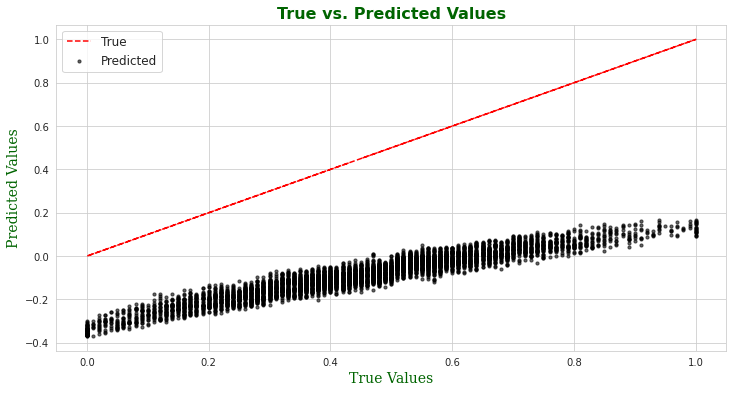

In [47]:
show_comparison(y_val, 
                ols_results_val.predict(sm.add_constant(X_val_std)))

We have an $adjusted \space R^2$ value of $0.917$, which seems nice but pretty bad error & prediction values. Also, as we predicted, **Date of Joining** and **Company Type** features are unfortunatelly not statically significant since **p-values** > 0.05. Before we move on to other models, let's check the linear regression assumptions for fun. Some of these assumptions may be satisfied and some may not :( <br>Anyways, we will keep trying the other models and comment at the end.

#### 3.2.1.1 Linear Regression Assumptions

In [48]:
# Assumption: Error term should be near zero in means
predict = ols_results.predict(X_train_ols)
errors = y_train - predict
print("The average error between the predicted & real value: \
{:.3g}".format(np.mean(errors)))

The average error between the predicted & real value: 6.85e-16


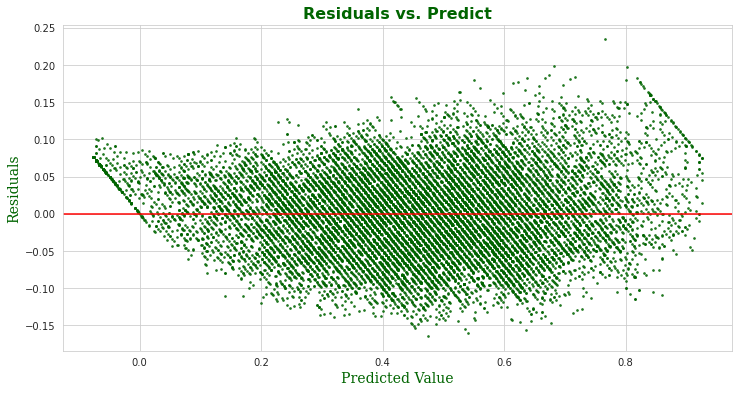

In [49]:
# Assumption: Homoscedasticity 
# i.e the error variance mustn't systematically change across the observations.
plt.figure(figsize=(12,6))
plt.scatter(predict, errors, color="darkgreen", s=3, alpha=0.75)
plt.xlabel('Predicted Value', fontdict=axis_font)
plt.ylabel('Residuals', fontdict=axis_font)
plt.axhline(y=0, color="r")
plt.title('Residuals vs. Predict', fontdict=title_font)
plt.show()

**Bartlett** and the **Levene** tests will confirm this assumption. The null hypothesis for both tests is that the errors are ***homoscedastic***.<br>If the p-values < 0.05, the hypothesis will be rejected (i.e **heteroscedastic**).

In [50]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predict, errors)
lev_stats = levene(predict, errors)

print("Bartlett test statistic value is {0:.2f} \
and p-value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:.2f} \
and p-value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 20563.47 and p-value is 0
Levene test statistic value is 13323.80 and p-value is 0


In [51]:
# Assumption: Low multicollinearity
# We saw that there are high collinearities among the features :(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


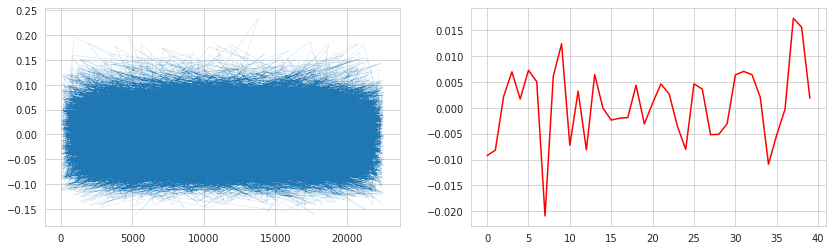

In [52]:
# Assumption: Error terms should be uncorrelated with one another
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(errors, linewidth=0.1)

plt.subplot(1,2,2)
from statsmodels.tsa.stattools import acf
acf_data = acf(errors)
plt.plot(acf_data[1:], color="red")
plt.show()

From the first figure, we will see that the errors are uncorrelated where the second one implies very low autocorrelation among the errors (see the extremely low values). By the way, *autocorrelation function*, **acf()** computes the variables' correlation with each other.

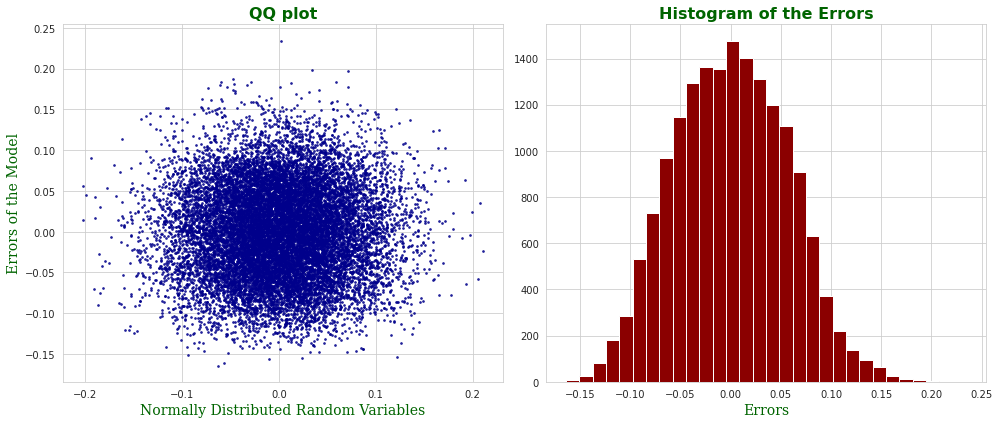

In [53]:
# Assumption: Features also shouldn't be correlated with the errors (exogeneity)
rand_nums = np.random.normal(np.mean(errors), 
                             np.std(errors), 
                             len(errors))
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(rand_nums, errors, color="darkblue", s=3, alpha=0.75)
plt.xlabel("Normally Distributed Random Variables", fontdict=axis_font)
plt.ylabel("Errors of the Model", fontdict=axis_font)
plt.title("QQ plot", fontdict=title_font)

plt.subplot(1,2,2)
plt.hist(errors, bins=30, color="darkred")
plt.xlabel("Errors", fontdict=axis_font)
plt.title("Histogram of the Errors", fontdict=title_font)

plt.tight_layout()
plt.show()

If this assumption doesn't hold, our predicted values would be biased. Thankfully, blue cloud shows us the independency between our variables and the errors. Also the histogram tells us whether the errors have normal distribution or not. It seems so but we need to check them statistically. **Jarque Bera** and **normal** tests tell us the truth. The null hypothesis of these tests are the errors being normally distributed.

In [54]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0:.2f} and \
p value is {1:.5g}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0:.2f} and p \
value is {1:5g}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 128.18 and p value is 0
Normality test statistics is 184.62 and p value is 8.11763e-41


...and the null hypotheses are rejected. They do not have normal distributions. Shoot... ¯\\_(ツ)_/¯

### 3.2.2 Lasso Regression

In [55]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

In [56]:
lasso_CV_model = LassoCV(alphas=np.logspace(-8, 6, num=30, base=10.0), 
                         cv=10, 
                         n_jobs=-1)
lasso_CV = lasso_CV_model.fit(X_train_std, y_train)

lasso_CV_score = lasso_CV.score(X_train_std, y_train)
print(f"Adjusted R-square value of train set: {lasso_CV_score:.3f}")
lasso_CV_score = lasso_CV.score(X_val_std, y_val)
print(f"Adjusted R-square value of validation set: {lasso_CV_score:.3f}")

show_errors(y_val, lasso_CV.predict(X_val_std))

Adjusted R-square value of train set: 0.919
Adjusted R-square value of validation set: 0.917

---------Error Statistics of Validation Part---------
Mean Absolute Error (MAE)             : 0.0467
Mean Square Error (MSE)               : 0.0033
Root Mean Square Error (RMSE)         : 0.0571



### 3.2.3 Ridge Regression

In [57]:
ridge_CV_model = RidgeCV(alphas=np.logspace(-8, 6, num=30, base=10.0), 
                         cv=10)
ridge_CV = ridge_CV_model.fit(X_train_std, y_train)

ridge_CV_score = ridge_CV.score(X_train_std, y_train)
print(f"Adjusted R-square value of train set: {ridge_CV_score:.3f}")
ridge_CV_score = ridge_CV.score(X_val_std, y_val)
print(f"Adjusted R-square value of validation set: {ridge_CV_score:.3f}")

show_errors(y_val, ridge_CV.predict(X_val_std))

Adjusted R-square value of train set: 0.919
Adjusted R-square value of validation set: 0.917

---------Error Statistics of Validation Part---------
Mean Absolute Error (MAE)             : 0.0467
Mean Square Error (MSE)               : 0.0033
Root Mean Square Error (RMSE)         : 0.0571



### 3.2.4 ElasticNet Regression

In [58]:
elasticNet_CV = ElasticNetCV(alphas=np.logspace(-6, 6, 30), 
                             l1_ratio=0.5, 
                             cv=10).fit(X_train_std, y_train)
elasticNet_score = elasticNet_CV.score(X_train_std, y_train)

elasticNet_CV_score = elasticNet_CV.score(X_train_std, y_train)
print(f"Adjusted R-square value of train set: {elasticNet_CV_score:.3f}")
elasticNet_CV_score = elasticNet_CV.score(X_val_std, y_val)
print(f"Adjusted R-square value of validation set: {elasticNet_CV_score:.3f}")

show_errors(y_val, elasticNet_CV.predict(X_val_std))

Adjusted R-square value of train set: 0.919
Adjusted R-square value of validation set: 0.917

---------Error Statistics of Validation Part---------
Mean Absolute Error (MAE)             : 0.0467
Mean Square Error (MSE)               : 0.0033
Root Mean Square Error (RMSE)         : 0.0571



### 3.2.5 Lasso Regression with Polynomial Features

Since **Lasso** will do the feature selection for us *(remember the statistically insignificant features)*, it would be a wise choice to apply polynomial features over it.

In [59]:
from sklearn.preprocessing import PolynomialFeatures

In [60]:
import warnings; warnings.filterwarnings("ignore")

poly = PolynomialFeatures(degree=4, 
                          interaction_only=False, 
                          order="F")
X_train_poly = poly.fit_transform(X_train_std)
X_val_poly = poly.fit_transform(X_val_std)

lasso_CV_poly = LassoCV(alphas=np.logspace(-8, 6, num=30, base=10.0), 
                        cv=10, 
                        n_jobs=-1).fit(X_train_poly, y_train)

lasso_score_poly = lasso_CV_poly.score(X_train_poly, y_train)
print(f"Adjusted R-square value of train set: {lasso_score_poly:.3f}")
lasso_score_poly = lasso_CV_poly.score(X_val_poly, y_val)
print(f"Adjusted R-square value of validation set: {lasso_score_poly:.3f}")

show_errors(y_val, lasso_CV_poly.predict(X_val_poly))

Adjusted R-square value of train set: 0.926
Adjusted R-square value of validation set: 0.923

---------Error Statistics of Validation Part---------
Mean Absolute Error (MAE)             : 0.0448
Mean Square Error (MSE)               : 0.0030
Root Mean Square Error (RMSE)         : 0.0548



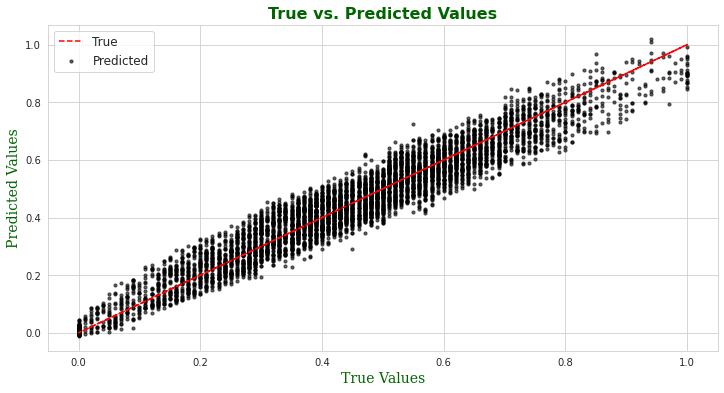

In [61]:
show_comparison(y_val, lasso_CV_poly.predict(X_val_poly))

Let's keep the data with polynomial features. It seems quite okay. We submit the data and see what happens later.<br> ***(PS: We hit almost $92.7\% \space R^2$ value! I'm among the first 50 even at this point.)***

In [62]:
import datetime
def export_output(algorithm, 
                  test_data, 
                  name=datetime.datetime.now().strftime("hour%H%M") + "_output"):
    """This function exports the predicted test data as a .csv file.
    Three input needs to be provided:
    1) The model you wish to use e.g "lasso_CV_poly",
    2) Predictions created by X_test, X_test_std or something similar,
    3) (optional) Name for the output e.g 'lasso_output'."""
    test_predict = algorithm.predict(test_data)
    predicted_output = pd.concat([pd.Series(test.iloc[:, 0]), 
                                            pd.Series(test_predict)],
                                 axis=1)
    wrong_column_name = predicted_output.columns[-1]
    predicted_output.rename(columns = {wrong_column_name:"Burn Rate"},
                            inplace=True)
    predicted_output.to_csv(path_or_buf=(name + ".csv"), 
                            index=False)
    predicted_output.head()

In [63]:
# export_output(lasso_CV_poly, poly.fit_transform(X_test_std), 
#               name = "lassoPoly_output")

In [64]:
# %whos    # to check who is getting in our way

In [65]:
# Let's clean up the place before we continue.
del lasso_CV_score, ridge_CV_score, elasticNet_CV_score, poly, LassoCV, RidgeCV,\
    lasso_score_poly, warnings, jarque_bera, bartlett,\
    norm_stats, jb_stats, rand_nums, acf_data, X_val_ols, bart_stats,\
    lev_stats, predict, errors, X_train_ols, ols_results_model, ols_results,\
    ols_results_val_model, ols_results_val, lasso_CV_model, lasso_CV, ridge_CV,\
    ridge_CV_model, resource_nan, mental_nan, burnrate_nan, acf, ElasticNetCV,\
    month_dict, fill_with, elasticNet_CV, elasticNet_score, train_corr, levene,\

## 3.3 k-Nearest Neighbors

In [114]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
knn_model = KNeighborsRegressor(n_jobs=-1)
knn_params = {"n_neighbors":range(10,20), 
              "weights":("uniform", "distance"), 
              "metric":("euclidean", "minkowski", "manhattan")
              }

In [66]:
def train_model(estimator, parameters, cv=10, verbose=1, X_data=X_train_std):
    """Function to train your model with a grid search.
    Just provide the function an estimator and its parameters.
    'estimator' example: knn_model
    'parameters' example: knn_params
    Optionally, you can change 'cv', 'verbose' or X_input as well."""
    gridCV = GridSearchCV(estimator=estimator, 
                          param_grid=parameters, 
                          n_jobs=-1, 
                          cv=cv, 
                          verbose=verbose)
    gridCV.fit(X_data, y_train)

    print("\nBest training parameters:", gridCV.best_params_)
    print("Best training score: {:.4f}".format(gridCV.best_score_))
    show_errors(y_val, gridCV.predict(X_val_std))
    return gridCV

In [ ]:
knn_gridCV = train_model(knn_model, knn_params)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  1.7min finished



Best training parameters: {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'distance'}
Best training score: 0.9117

---------Error Statistics of Validation Part---------
Mean Absolute Error (MAE)             : 0.047
Mean Square Error (MSE)               : 0.003
Root Mean Square Error (RMSE)         : 0.058



In [ ]:
knn_results = pd.DataFrame(knn_gridCV.cv_results_)
knn_results = knn_results[["param_metric", "param_n_neighbors",
                           "param_weights", "mean_test_score"]]
knn_results = knn_results.sort_values(by="mean_test_score", ascending=False)
knn_results.head()

,param_metric,param_n_neighbors,param_weights,mean_test_score
69,minkowski,19,distance,0.911713
29,euclidean,19,distance,0.911713
67,minkowski,18,distance,0.911709
27,euclidean,18,distance,0.911709
71,minkowski,20,distance,0.911662


Close but not enough!

## 3.4 Decision Trees

In [ ]:
# import pydotplus, graphviz
# from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor    #, export_graphviz

In [ ]:
tree_model = DecisionTreeRegressor(random_state=19)
tree_params = {"max_depth":range(8,10), 
               "min_samples_split":range(2,5), 
               "splitter":("best", "random"), 
               "min_samples_leaf":range(5,15)
              }

tree_gridCV = train_model(tree_model, tree_params)

Fitting 10 folds for each of 304 candidates, totalling 3040 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Best training parameters: {'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
Best training score: 0.9231

---------Error Statistics of Validation Part---------
Mean Absolute Error (MAE)             : 0.044
Mean Square Error (MSE)               : 0.003
Root Mean Square Error (RMSE)         : 0.055



[Parallel(n_jobs=1)]: Done 3040 out of 3040 | elapsed:   48.1s finished


In [ ]:
tree_results = pd.DataFrame(tree_gridCV.cv_results_)
tree_results = tree_results[["param_max_depth", 
                             "param_min_samples_split",
                             "param_splitter", 
                             "param_min_samples_leaf", 
                             "mean_test_score"]]
tree_results = tree_results.sort_values(by="mean_test_score", 
                                        ascending=False)
tree_results.head()

,param_max_depth,param_min_samples_split,param_splitter,param_min_samples_leaf,mean_test_score
74,8,2,best,10,0.923123
76,8,3,best,10,0.923123
78,8,4,best,10,0.923123
82,8,2,best,11,0.923115
84,8,3,best,11,0.923115


In [ ]:
# export_output(algorithm = tree_gridCV, test_data = X_test_std,
#               name = "decisionTree_output")

Decision tree results seem pretty good. Let's keep it as well.<br>
***PS: (After submission, we had a score slightly worse (~0.2%) than the Lasso model.)***

## 3.5 Random Forest

In [ ]:
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict

In [ ]:
# These values are from a series of everlasting grid searches.
forest_model = RandomForestRegressor(n_estimators=200, 
                                     max_depth=8, 
                                     criterion="mae", 
                                     min_samples_leaf=5, 
                                     min_samples_split=2, 
                                     random_state=19)

In [ ]:
forest_scoreCV = cross_val_score(estimator=forest_model, 
                                 X=X_train_std, 
                                 y=y_train, 
                                 cv=5, 
                                 verbose=2, 
                                 n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Training is completed in 884.91 seconds


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.7min finished


In [ ]:
print(f"Mean score of Random Forest model: {forest_scoreCV.mean():.3f}")

Mean score of Random Forest model: 0.924


In [ ]:
forest_predictCV = cross_val_predict(estimator=forest_model, 
                                     X=X_val_std, 
                                     y=y_val, 
                                     cv=5, 
                                     verbose=2, 
                                     n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


In [ ]:
show_errors(y_val, forest_predictCV)


---------Error Statistics of Validation Part---------
Mean Absolute Error (MAE)             : 0.044
Mean Square Error (MSE)               : 0.003
Root Mean Square Error (RMSE)         : 0.056



We are still slightly behind **Lasso with polynomial features** model. The submitted score confirmed this :( Maybe a better hyperparameter tuning would succeed to Lasso's throne but it would take many hours to find out. Let's display the most significant variables to turn this all "random forest time waste" into something useful. So we can make sure which features have the most impact on our model.

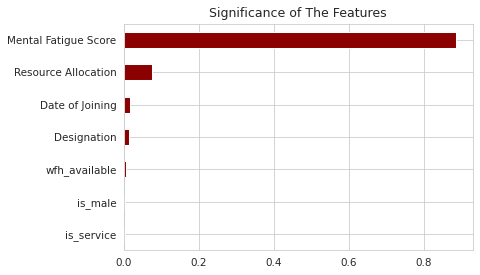

In [ ]:
# Variable named 'sp' stands for 'significant pairs'
forest_model.fit(X_val_std, y_val)

sp = dict(zip(X_train.columns, forest_model.feature_importances_))
# sorting w.r.t their significance values:
sp = {k: v for k, v in sorted(sp.items(), key=lambda i: i[1], reverse=True)}

significant_names = list(sp.keys())
significant_values = list(sp.values())

significance = pd.Series(data=significant_values,
                         index=significant_names).sort_values()
plt.figure(dpi=75)
significance.plot(kind="barh", color="darkred")
plt.title("Significance of The Features")
plt.show()
del sp, significant_names, significant_values, significance

## 3.6 Support Vector Machines

In [ ]:
from sklearn.svm import SVR

In [ ]:
time_start = time.time()
svm_model = SVR(C=0.01, kernel="linear")    # grid searched prior to this
svm_params = {"epsilon":np.arange(0.01, 0.1, 0.02)}

svm_gridCV = train_model(svm_model, svm_params, cv=5)
print("\nTraining is completed in {:.2f} seconds".format(time.time() - time_start))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.2min finished



Best training parameters: {'epsilon': 0.049999999999999996}
Best training score: 0.9191

---------Error Statistics of Validation Part---------
Mean Absolute Error (MAE)             : 0.047
Mean Square Error (MSE)               : 0.003
Root Mean Square Error (RMSE)         : 0.057


Training is completed in 76.92 seconds


In [ ]:
svm_results = pd.DataFrame(svm_gridCV.cv_results_)
svm_results = svm_results[["param_epsilon", "mean_test_score"]]
svm_results = svm_results.sort_values(by="mean_test_score", 
                                            ascending=False)
svm_results.head()

,param_epsilon,mean_test_score
2,0.05,0.919073
1,0.03,0.918664
3,0.07,0.918479
0,0.01,0.918347
4,0.09,0.916590


I have high hopes for XGBoost.

## 3.7 XGBoost

In [117]:
import xgboost as xgb

In [654]:
xgb_model = xgb.XGBRegressor(booster="gbtree", 
                             gamma=0, 
                             max_depth=6, 
                             alpha=0, 
                             eta=0.1)
# again, after a series of grid search, this one is the last one:
xgb_params = {"objective":["reg:squarederror"],
              "n_estimators":[47], 
              "min_child_weight":[7]}

xgb_gridCV = train_model(xgb_model, xgb_params, cv=20, verbose=1)

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.7s finished



Best training parameters: {'min_child_weight': 7, 'n_estimators': 47, 'objective': 'reg:squarederror'}
Best training score: 0.9269

---------Error Statistics of Validation Part---------
Mean Absolute Error (MAE)             : 0.0436
Mean Square Error (MSE)               : 0.0029
Root Mean Square Error (RMSE)         : 0.0538



In [655]:
xgb_results = pd.DataFrame(xgb_gridCV.cv_results_)
xgb_results = xgb_results[["param_objective",  
                           "param_n_estimators", 
                           "param_min_child_weight", 
                           "mean_test_score"]]
xgb_results = xgb_results.sort_values(by="mean_test_score", 
                                            ascending=False)
xgb_results.head()

,param_objective,param_n_estimators,param_min_child_weight,mean_test_score
0,reg:squarederror,47,7,0.926918


In [369]:
# let's save this model too
export_output(xgb_gridCV, X_test_std, name="xgb_output")

XGBoost is the winner at this point. We improved our score and hit $92.9\% \space R^2$ value.

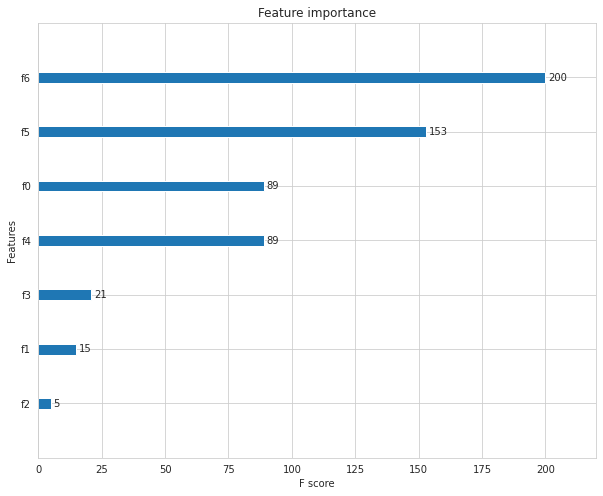

In [377]:
# feature importance
xgb_model2 = xgb.train(params=xgb_gridCV.best_params_, 
                      dtrain=xgb.DMatrix(data=X_train_std, label=y_train))
ax = xgb.plot_importance(xgb_model2)
ax.figure.set_size_inches(10, 8)
plt.show()

XGBoost seems to use our features more efficiently. We had a similar significance graph as random forest.<br>Now comes my favorite part: *Deep Learning* algorithm!<br>I'm not sure if we can beat XGBoost or not but we surely will try hard!

***
## 3.8 Artificial Neural Networks
Deep Learning Method, challenge accepted!

In [103]:
from keras import models, layers
from keras.optimizers import Adam, schedules

In [688]:
# to avoid repeating the layers
def dense_layer(unit):
    model.add(layers.Dense(units=unit))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))

Just one hidden layer with 16 neurons did the job without an overfit. (Note that we put the BatchNormalization in between to normalize the transition from linearity (dense layer) to non-linearity (activation function).

In [689]:
model = models.Sequential()
model.add(layers.Dense(units=16,
                       input_shape=(X_train_norm.shape[1], ), 
                       kernel_initializer="GlorotUniform", 
                       name="Hidden_Layer1"))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
#dense_layer(64)
model.add(layers.Dropout(0.05))
#dense_layer(128)
model.add(layers.Dense(1, name="Output_Layer"))
model.summary()

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer1 (Dense)        (None, 16)                128       
_________________________________________________________________
batch_normalization_109 (Bat (None, 16)                64        
_________________________________________________________________
activation_109 (Activation)  (None, 16)                0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 16)                0         
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 17        
Total params: 209
Trainable params: 177
Non-trainable params: 32
_________________________________________________________________


In [690]:
lr_schedule = schedules.ExponentialDecay(initial_learning_rate=1e-3,
                                         decay_steps=10000,
                                         decay_rate=0.9)

opt = Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt, loss="mse", metrics=["mae"])
model_history = model.fit(X_train_norm, y_train, 
                          epochs=20, 
                          batch_size=32, 
                          validation_data=(X_val_norm, y_val), 
                          shuffle=False, 
                          verbose=0)

In [691]:
show_errors(y_val, model.predict(X_val_norm).reshape(-1))


---------Error Statistics of Validation Part---------
Mean Absolute Error (MAE)             : 0.0464
Mean Square Error (MSE)               : 0.0033
Root Mean Square Error (RMSE)         : 0.0571



We need no more than 20 epochs. It's a waste of time. Trust me, I tried ten times more epochs and nothing really changed anyway. If you don't believe me, take a look at the graph below. Loss value of the validation set goes horizontal.

In [692]:
history_dict = model_history.history

train_loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
train_mae = history_dict["mae"]
val_mae = history_dict["val_mae"]

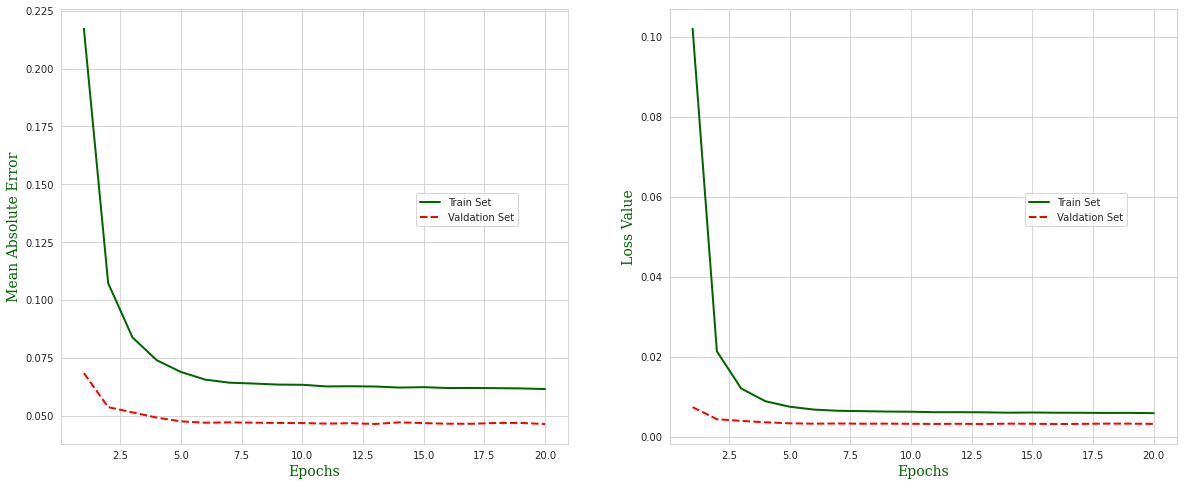

In [693]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(range(1, len(train_mae)+1), train_mae, 
         color="darkgreen", linewidth=2, label="Train Set")

plt.plot(range(1, len(val_mae)+1), val_mae, 
        "r--", linewidth=2, label="Valdation Set")

plt.xlabel("Epochs", fontdict=axis_font)
plt.ylabel("Mean Absolute Error", fontdict=axis_font)
plt.legend(fontsize="medium", loc=(0.7,0.5))

plt.subplot(1,2,2)
plt.plot(range(1, len(train_loss)+1), train_loss, 
         color="darkgreen", linewidth=2, label="Train Set")

plt.plot(range(1, len(val_loss)+1), val_loss, 
        "r--", linewidth=2, label="Valdation Set")

plt.xlabel("Epochs", fontdict=axis_font)
plt.ylabel("Loss Value", fontdict=axis_font)
plt.legend(fontsize="medium", loc=(0.7,0.5))

plt.show()

***

# 4\. Final Thoughts

1) **XGBoost** won the game. I couldn't manage to go beyond 93% **(92.89% to be exact)** while the first place of the leaderboard is occupied by a score of 93.12%. Yeah, sometimes you all need a 0.2% bump and you just can't make it. The hackathon is about to end as I'm writing this and got the 58th place *(out of 500+ attendees, which doesn't seem bad)*. That little difference got me fall behind 50+ people.

2) I also have a confession to make: If we skipped the whole NaN value modification and just killed them all with <code>pandas.DataFrame.dropna()</code> function, we would have had better results in all of the models except our *champ* XGBoost. Killing all the NaNs and running the dataset on XGBoost almost gave me the same score but not as high as the original one that you see above. Deep learning & linear regression models did better on the latter dataset but the overall winner stayed the same.<br>DL models disappointed me but it was a simple dataset anyway. I cannot put the blame on them.

3) Remember the insignificant features? The score didn't change when they were out either. I also tried some feature engineering (as *Polynomial Feature* function did by itself up to 4th degree) by hand but no avail. I hope this notebook helps beginners along the way. Peace.